In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Conv1D, GlobalAveragePooling1D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import seaborn as sb

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

train.head

#survival 이 label
# NaN 처리 해야
"""
passengerId index 승객 번호
name categorical string 이름
survival	 label 생존 여부
pclass	categorical 경제적 위치? 1이 높은것 ordinal 아닌가?
sex	categorical 성별
Age	discrete 나이
sibsp	discrete 형제 자매 남편/부인의 수
parch	discrete 자식 
ticket	categorical 이지만 string 티켓 번호
fare	continuous 요금
cabin	categorical 이지만 string 캐비넷 번호
embarked categorical 승선지

애매하다고 생각하는 feature의 경우 그래프를 그려서 확인해보는 것이 좋음
성별, pclass, 나이, sibasp, parch, fare의 경우 어느정도 생존성과 관련이 있다고 생각할 수 있음
name, ticket, cabin, embarked는 확인해보아야함.


"""

'\npassengerId index 승객 번호\nname categorical string 이름\nsurvival\t label 생존 여부\npclass\tcategorical 경제적 위치? 1이 높은것 ordinal 아닌가?\nsex\tcategorical 성별\nAge\tdiscrete 나이\nsibsp\tdiscrete 형제 자매 남편/부인의 수\nparch\tdiscrete 자식 \nticket\tcategorical 이지만 string 티켓 번호\nfare\tcontinuous 요금\ncabin\tcategorical 이지만 string 캐비넷 번호\nembarked categorical 승선지\n\n애매하다고 생각하는 feature의 경우 그래프를 그려서 확인해보는 것이 좋음\n성별, pclass, 나이, sibasp, parch, fare의 경우 어느정도 생존성과 관련이 있다고 생각할 수 있음\nname, ticket, cabin, embarked는 확인해보아야함.\n\n\n'

In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
print("duplicated train data: ", train.duplicated().sum())
print("duplicated test data: ", test.duplicated().sum())

duplicated train data:  0
duplicated test data:  0


<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

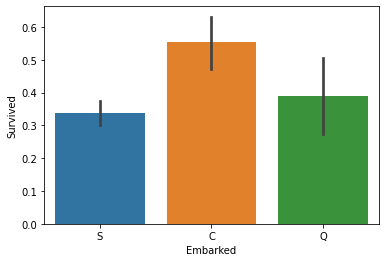

In [8]:
sb.barplot(data = train, x = 'Embarked', y = 'Survived')

In [9]:
# name은 조금 특별함. 왜냐하면 Mr. Mis Miss 등으로 성별, 결혼 유무 등을 확인할 수 있기 때문
# 따라서  name에서 이러한 것들을 추출할 필요가 있음
train['Name'].head

<bound method NDFrame.head of 0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object>

In [10]:
train = train.drop(['Name','Ticket', 'Cabin'], axis = 'columns')

In [11]:
train_y = train.pop('Survived')

In [12]:
train = train.drop(['PassengerId'], axis = 'columns')

In [13]:
train['Embarked'] = train.Embarked.fillna('S')

In [14]:
train.head

<bound method NDFrame.head of      Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         3    male  22.0      1      0   7.2500        S
1         1  female  38.0      1      0  71.2833        C
2         3  female  26.0      0      0   7.9250        S
3         1  female  35.0      1      0  53.1000        S
4         3    male  35.0      0      0   8.0500        S
..      ...     ...   ...    ...    ...      ...      ...
886       2    male  27.0      0      0  13.0000        S
887       1  female  19.0      0      0  30.0000        S
888       3  female   NaN      1      2  23.4500        S
889       1    male  26.0      0      0  30.0000        C
890       3    male  32.0      0      0   7.7500        Q

[891 rows x 7 columns]>

In [15]:
train = pd.get_dummies(train, columns = ['Pclass'], prefix='Pclass')

In [16]:
train = pd.get_dummies(train, columns = ['Sex'], prefix='Sex')

In [17]:
train = pd.get_dummies(train, columns = ['Embarked'], prefix='Embarked')

In [18]:
train.head

<bound method NDFrame.head of       Age  SibSp  Parch     Fare  Pclass_1  Pclass_2  Pclass_3  Sex_female  \
0    22.0      1      0   7.2500         0         0         1           0   
1    38.0      1      0  71.2833         1         0         0           1   
2    26.0      0      0   7.9250         0         0         1           1   
3    35.0      1      0  53.1000         1         0         0           1   
4    35.0      0      0   8.0500         0         0         1           0   
..    ...    ...    ...      ...       ...       ...       ...         ...   
886  27.0      0      0  13.0000         0         1         0           0   
887  19.0      0      0  30.0000         1         0         0           1   
888   NaN      1      2  23.4500         0         0         1           1   
889  26.0      0      0  30.0000         1         0         0           0   
890  32.0      0      0   7.7500         0         0         1           0   

     Sex_male  Embarked_C  Embark

In [19]:
train.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [20]:
cols = ['SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

train_with_na = train[train['Age'].isnull()]
train_without_na = train[train['Age'].isnull() == False]

In [21]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5)

rfr.fit(train_without_na[cols], train_without_na['Age'])

RandomForestRegressor(max_depth=5)

In [22]:
train_with_na['Age'] = rfr.predict(train_with_na[cols]).astype('int32')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
train = train_without_na.append(train_with_na)

In [24]:
train.head

<bound method NDFrame.head of       Age  SibSp  Parch     Fare  Pclass_1  Pclass_2  Pclass_3  Sex_female  \
0    22.0      1      0   7.2500         0         0         1           0   
1    38.0      1      0  71.2833         1         0         0           1   
2    26.0      0      0   7.9250         0         0         1           1   
3    35.0      1      0  53.1000         1         0         0           1   
4    35.0      0      0   8.0500         0         0         1           0   
..    ...    ...    ...      ...       ...       ...       ...         ...   
859  28.0      0      0   7.2292         0         0         1           0   
863  10.0      8      2  69.5500         0         0         1           1   
868  27.0      0      0   9.5000         0         0         1           0   
878  28.0      0      0   7.8958         0         0         1           0   
888  20.0      1      2  23.4500         0         0         1           1   

     Sex_male  Embarked_C  Embark

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 888
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   SibSp       891 non-null    int64  
 2   Parch       891 non-null    int64  
 3   Fare        891 non-null    float64
 4   Pclass_1    891 non-null    uint8  
 5   Pclass_2    891 non-null    uint8  
 6   Pclass_3    891 non-null    uint8  
 7   Sex_female  891 non-null    uint8  
 8   Sex_male    891 non-null    uint8  
 9   Embarked_C  891 non-null    uint8  
 10  Embarked_Q  891 non-null    uint8  
 11  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 41.8 KB


In [26]:
test = test.drop(['Name','Ticket', 'Cabin'], axis = 'columns')
test = test.drop(['PassengerId'], axis = 'columns')

test = pd.get_dummies(test, columns = ['Pclass'], prefix='Pclass')
test = pd.get_dummies(test, columns = ['Sex'], prefix='Sex')
test = pd.get_dummies(test, columns = ['Embarked'], prefix='Embarked')

In [27]:
cols = ['SibSp', 'Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

test_with_na_fare = test[test['Fare'].isnull()]
test_without_na_fare = test[test['Fare'].isnull() == False]

In [28]:
rfr2 = RandomForestRegressor(n_estimators=100, max_depth=5)

rfr2.fit(test_without_na_fare[cols], test_without_na_fare['Fare'])

RandomForestRegressor(max_depth=5)

In [29]:
test_with_na_fare['Fare'] = rfr2.predict(test_with_na_fare[cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
test = test_without_na_fare.append(test_with_na_fare)
test.head

<bound method NDFrame.head of       Age  SibSp  Parch        Fare  Pclass_1  Pclass_2  Pclass_3  Sex_female  \
0    34.5      0      0    7.829200         0         0         1           0   
1    47.0      1      0    7.000000         0         0         1           1   
2    62.0      0      0    9.687500         0         1         0           0   
3    27.0      0      0    8.662500         0         0         1           0   
4    22.0      1      1   12.287500         0         0         1           1   
..    ...    ...    ...         ...       ...       ...       ...         ...   
414  39.0      0      0  108.900000         1         0         0           1   
415  38.5      0      0    7.250000         0         0         1           0   
416   NaN      0      0    8.050000         0         0         1           0   
417   NaN      1      1   22.358300         0         0         1           0   
152  60.5      0      0    9.073294         0         0         1           0  

In [31]:
cols = ['SibSp','Fare', 'Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

test_with_na_age2 = test[test['Age'].isnull()]
test_without_na_age2 = test[test['Age'].isnull() == False]

rfr3 = RandomForestRegressor(n_estimators=100, max_depth=5)

rfr3.fit(test_without_na_age2[cols], test_without_na_age2['Age'])

test_with_na_age2['Age'] = rfr3.predict(test_with_na_age2[cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [32]:
test = test_without_na_age2.append(test_with_na_age2)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 888
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   SibSp       891 non-null    int64  
 2   Parch       891 non-null    int64  
 3   Fare        891 non-null    float64
 4   Pclass_1    891 non-null    uint8  
 5   Pclass_2    891 non-null    uint8  
 6   Pclass_3    891 non-null    uint8  
 7   Sex_female  891 non-null    uint8  
 8   Sex_male    891 non-null    uint8  
 9   Embarked_C  891 non-null    uint8  
 10  Embarked_Q  891 non-null    uint8  
 11  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 41.8 KB


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   SibSp       418 non-null    int64  
 2   Parch       418 non-null    int64  
 3   Fare        418 non-null    float64
 4   Pclass_1    418 non-null    uint8  
 5   Pclass_2    418 non-null    uint8  
 6   Pclass_3    418 non-null    uint8  
 7   Sex_female  418 non-null    uint8  
 8   Sex_male    418 non-null    uint8  
 9   Embarked_C  418 non-null    uint8  
 10  Embarked_Q  418 non-null    uint8  
 11  Embarked_S  418 non-null    uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 19.6 KB


In [35]:
rs = RobustScaler()
train_x = rs.fit_transform(train)
test_x = rs.transform(test)


In [36]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

params = {
    'max_depth' : [3, 5, 10],
    'n_estimators' : [50, 100, 500],
    
}

from sklearn.model_selection import GridSearchCV

gscv = GridSearchCV(gbc, param_grid = params, scoring='accuracy')

gscv.fit(train_x, train_y)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 500]},
             scoring='accuracy')

In [37]:
gscv.best_params_

{'max_depth': 3, 'n_estimators': 50}

In [38]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=50)

model.fit(train_x, train_y)

GradientBoostingClassifier(n_estimators=50)

In [39]:
y = model.predict(test_x)
sub['Survived'] = y

In [40]:
sub.head

<bound method NDFrame.head of      PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         1
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]>

In [41]:
sub.to_csv('/kaggle/working/submission.csv')